# Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# 1. Загрузка и подготовка данных

## Описание данных
Данные геологоразведки трёх регионов находятся в файлах:
- geo_data_0.csv.
- geo_data_1.csv.
- geo_data_2.csv.

`id` — уникальный идентификатор скважины;

`f0, f1, f2` — три признака точек (неважно, что они означают, но сами признаки значимы);

`product` — объём запасов в скважине (тыс. баррелей).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sb
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV # разбиение на выборки, подбор параметров
from sklearn.linear_model import LinearRegression # линейная регрессия
from sklearn.metrics import mean_squared_error

In [2]:
# настройки
pd.set_option('float_format', '{:,.2f}'.format)

In [3]:
# задаем сразу необходимые типы данных, если необходимо
types = {
#     'example':'int64',
}
columns = [
    'id', # уникальный индекс скважины
    'f0',
    'f1',
    'f2',
    'product',
]

In [4]:
# универсальное чтение данных
names = [
    'geo_data_0.csv',
    'geo_data_1.csv',
    'geo_data_2.csv',
]

try:
    # local
    data_0 = pd.read_csv("./datasets/" + names[0], dtype=types, usecols=columns)
    data_1 = pd.read_csv("./datasets/" + names[1], dtype=types, usecols=columns)
    data_2 = pd.read_csv("./datasets/" + names[2], dtype=types, usecols=columns)
except:
    try:
        # https://jupyterhub.praktikum-services.ru/
        data_0 = pd.read_csv("/datasets/" + names[0], dtype=types, usecols=columns)
        data_1 = pd.read_csv("/datasets/" + names[1], dtype=types, usecols=columns)
        data_2 = pd.read_csv("/datasets/" + names[2], dtype=types, usecols=columns)
    except:
        # https://praktikum.yandex.ru/
        data_0 = pd.read_csv("https://..." + names[0], dtype=types, usecols=columns)
        data_1 = pd.read_csv("https://..." + names[1], dtype=types, usecols=columns)
        data_2 = pd.read_csv("https://..." + names[2], dtype=types, usecols=columns)
finally:
    display(data_0.info())
    display(data_0.head())
    display(data_1.info())
    display(data_1.head())
    display(data_2.info())
    display(data_2.head()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,txEyH,0.71,-0.50,1.22,105.28
1,2acmU,1.33,-0.34,4.37,73.04
2,409Wp,1.02,0.15,1.42,85.27
3,iJLyR,-0.03,0.14,2.98,168.62
4,Xdl7t,1.99,0.16,4.75,154.04


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,kBEdx,-15.00,-8.28,-0.01,3.18
1,62mP7,14.27,-3.48,1.00,26.95
2,vyE1P,6.26,-5.95,5.00,134.77
3,KcrkZ,-13.08,-11.51,5.00,137.95
4,AHL4O,12.70,-8.15,5.00,134.77


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,id,f0,f1,f2,product
0,fwXo0,-1.15,0.96,-0.83,27.76
1,WJtFt,0.26,0.27,-2.53,56.07
2,ovLUW,0.19,0.29,-5.59,62.87
3,q6cA6,2.24,-0.55,0.93,114.57
4,WPMUX,-0.52,1.72,5.90,149.60


Оценим визуально входные данные

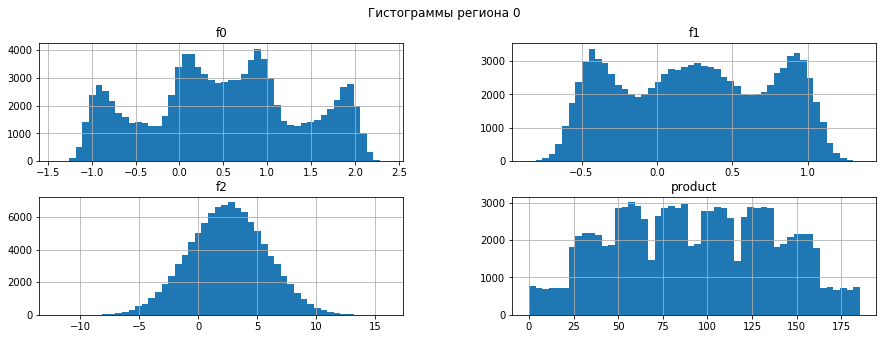

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(15,5))
data_0.hist(bins=50, ax=ax)
fig.suptitle('Гистограммы региона 0')
plt.show()

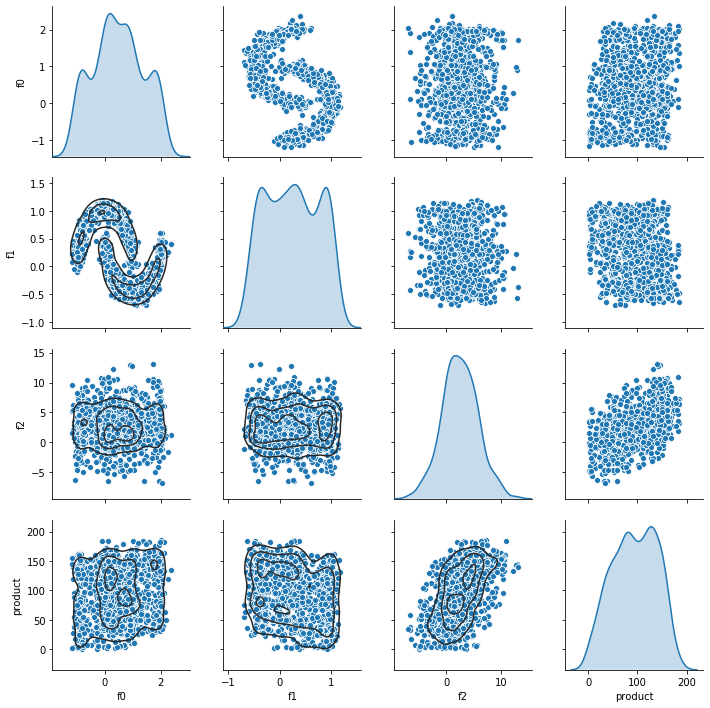

In [6]:
df = data_0.sample(1000)
g = sb.pairplot(df,diag_kind = "kde")
g.map_lower(sb.kdeplot, levels=3, color=".2")
plt.show()

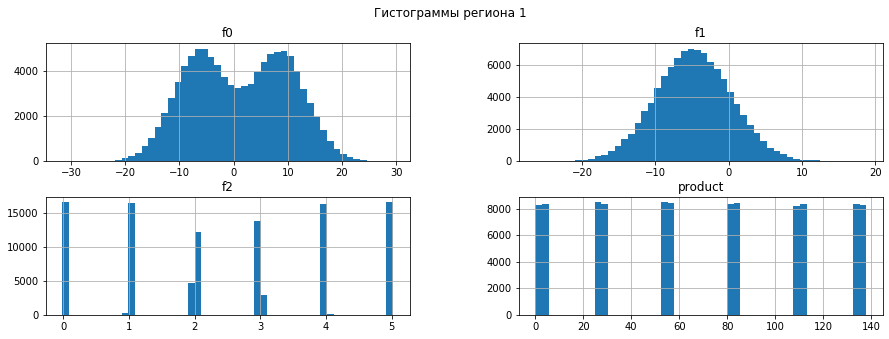

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(15,5))
data_1.hist(bins=50, ax=ax)
fig.suptitle('Гистограммы региона 1')
plt.show()

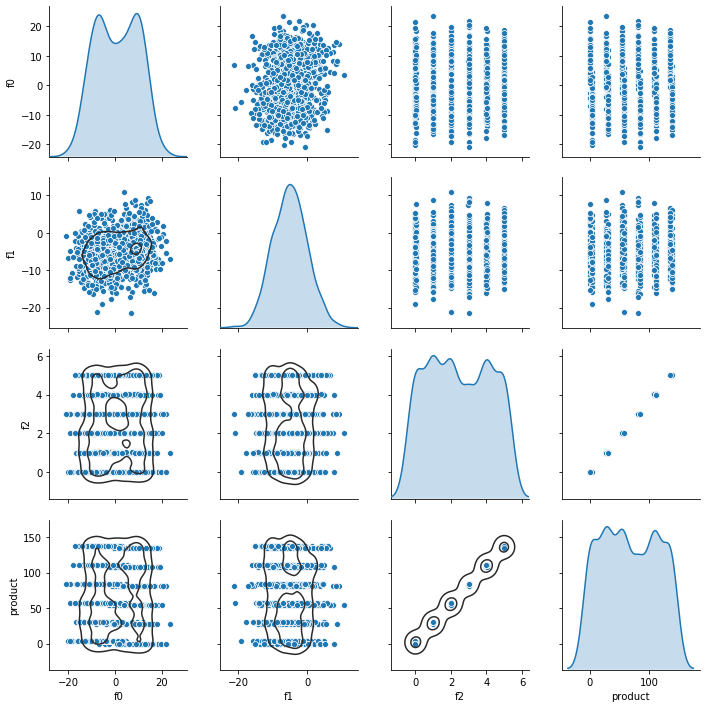

In [8]:
df = data_1.sample(1000)
g = sb.pairplot(df,diag_kind = "kde")
g.map_lower(sb.kdeplot, levels=2, color=".2")
plt.show()

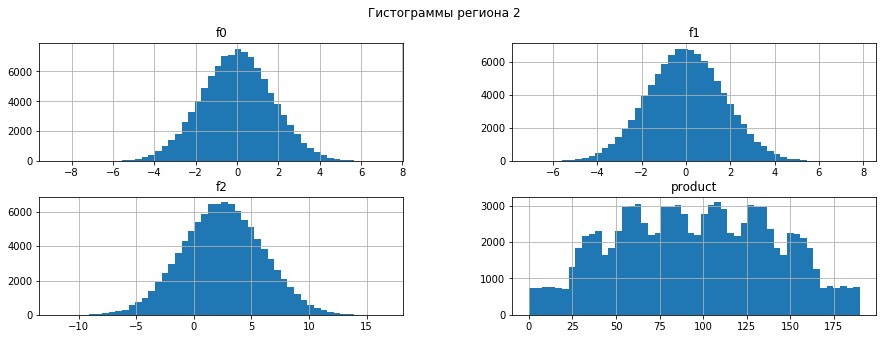

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(15,5))
data_2.hist(bins=50, ax=ax)
fig.suptitle('Гистограммы региона 2')
plt.show()

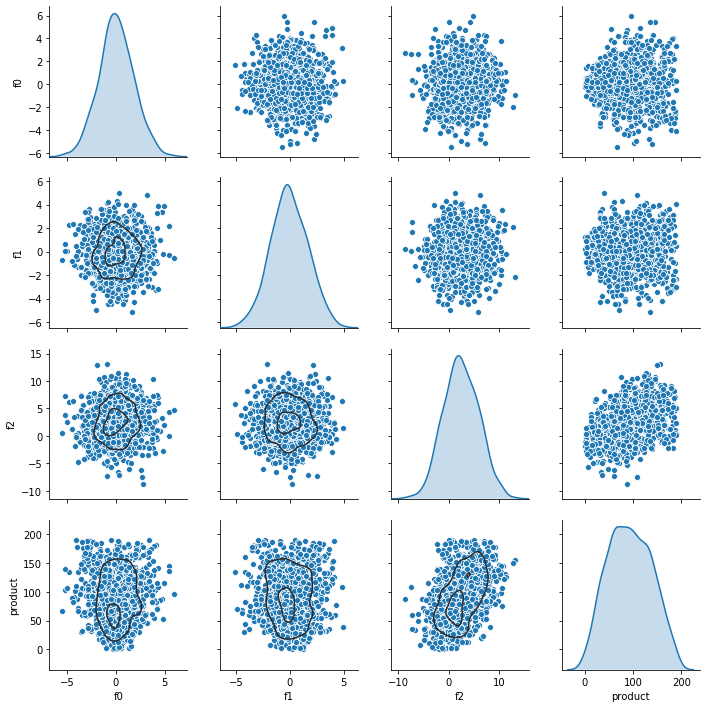

In [10]:
df = data_2.sample(1000)
g = sb.pairplot(df,diag_kind = "kde")
g.map_lower(sb.kdeplot, levels=2, color=".2")
plt.show()

Предоставленные данные уже неплохо подготовлены. Считаю, что дополнительных манипуляций тут не требуется.

В глаза бросается явная зависимость целевого признака от `f2` в регионе 1. Возможно произошла утечка целевого признака.

Так же интересно выглядит зависимость `f0` от `f1` в регионе 0. Вероятнее всего это результат работы генератора этих данных (ну или это массонское вмешательство ¯\\\_(ツ)\_/¯ )

# 2. Обучение и проверка модели

In [34]:
model = LinearRegression()

## Регион 0

In [12]:
features_0 = data_0.drop(columns=['id', 'product'])
target_0 = data_0['product']

In [13]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(
    features_0, target_0, test_size=0.25, random_state=12345)

In [14]:
model.fit(features_train_0, target_train_0)
predicted_0 = model.predict(features_valid_0)
# преобразуем к Series и проставляем корректные индексы
predicted_0 = pd.Series(predicted_0, index=features_valid_0.index)

In [15]:
print('Среднее значение целевого признака:', target_valid_0.mean())
print('Средний запас предсказанного сырья:', predicted_0.mean())
print('RMSE:', mean_squared_error(target_valid_0, predicted_0)**0.5)

Среднее значение целевого признака: 92.07859674082927
Средний запас предсказанного сырья: 92.59256778438038
RMSE: 37.5794217150813


## Регион 1

In [16]:
features_1 = data_1.drop(columns=['id', 'product'])
target_1 = data_1['product']

In [17]:
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(
    features_1, target_1, test_size=0.25, random_state=12345)

In [18]:
model.fit(features_train_1, target_train_1)
predicted_1 = model.predict(features_valid_1)
# преобразуем к Series и проставляем корректные индексы
predicted_1 = pd.Series(predicted_1, index=features_valid_1.index)

In [19]:
print('Среднее значение целевого признака:', target_valid_1.mean())
print('Средний запас предсказанного сырья:', predicted_1.mean())
print('RMSE:', mean_squared_error(target_valid_1, predicted_1)**0.5)

Среднее значение целевого признака: 68.72313602435997
Средний запас предсказанного сырья: 68.728546895446
RMSE: 0.893099286775616


## Регион 2

In [20]:
features_2 = data_2.drop(columns=['id', 'product'])
target_2 = data_2['product']

In [21]:
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(
    features_2, target_2, test_size=0.25, random_state=12345)

In [22]:
model.fit(features_train_2, target_train_2)
predicted_2 = model.predict(features_valid_2)
# преобразуем к Series и проставляем корректные индексы
predicted_2 = pd.Series(predicted_2, index=features_valid_2.index)

In [23]:
print('Среднее значение целевого признака:', target_valid_2.mean())
print('Средний запас предсказанного сырья:', predicted_2.mean())
print('RMSE:', mean_squared_error(target_valid_2, predicted_2)**0.5)

Среднее значение целевого признака: 94.88423280885438
Средний запас предсказанного сырья: 94.96504596800489
RMSE: 40.02970873393434


В регионе 1 подозрительно маленькая ошибка, можно подтвердить высказанное ранее предположение об утечке целевого признака.

В других регионах значительно выше RMSE, соответственно и риски для бинеса должны быть тоже выше.

# 3. Подготовка к расчёту прибыли

In [24]:
barrel_price = 450 * 1000
oil_wells_number = 500
dev_oil_wells_number = 200
regional_budget = 10**10

In [25]:
# Стоимость разработки одной скважины
dev_price_one_well = regional_budget / dev_oil_wells_number
print('Стоимость разработки одной скважины: {:.2f}'.format(dev_price_one_well))

# Мин объем сырья в скважине (тыс. баррелей) необходимый для окупаемости
min_product = dev_price_one_well / barrel_price
print('Мин объем сырья в скважине (тыс. баррелей) необходимый для окупаемости: {:.2f}'.format(min_product))

Стоимость разработки одной скважины: 50000000.00
Мин объем сырья в скважине (тыс. баррелей) необходимый для окупаемости: 111.11


Все полученные средние значения объемов сырья меньше 111, что больше средних значений по регионам. Следовательно, необходимо грамотно подходить к выбору разрабатываемых скважин.

## Функция рассчета прибыли

In [26]:
def revenue(target, predicted, count, barrel_price=barrel_price, regional_budget=regional_budget):
    # сортируем предсказанния
    probs_sorted = predicted.sort_values(ascending=False)
    # берем 200 лучших предсказаний и сопоставляем им реальные данные
    selected = target[probs_sorted.index][:count]
    # возвращаем прибыль
    return barrel_price * selected.sum() - regional_budget

In [27]:
test_predicted = predicted_2.sample(500, replace=True)
test_target = target_valid_2[test_predicted.index]

In [28]:
print('Макс возможная прибыль: {:.2e}'.format(test_target.sort_values(ascending=False)[:200].sum()*barrel_price - regional_budget))

Макс возможная прибыль: 2.70e+09


In [29]:
print('Предсказанная прибыль: {:.2e}'.format(test_predicted.sort_values(ascending=False)[:200].sum()*barrel_price - regional_budget))

Предсказанная прибыль: 3.30e+08


In [30]:
print('Реальная прибыль: {:.2e}'.format(revenue(test_target, test_predicted, dev_oil_wells_number, barrel_price, regional_budget)))

Реальная прибыль: 3.79e+08


# 4. Расчёт прибыли и рисков 

In [31]:
region = {
    0:[predicted_0, target_valid_0],
    1:[predicted_1, target_valid_1],
    2:[predicted_2, target_valid_2],
}

In [32]:
# по регионам
for i, [predicted, target] in region.items():
    print(f"Регион {i}:")
    
    state = np.random.RandomState(12345)
    values = []
    # бутстреп
    for i in range(1000):
        sample_pred = predicted.sample(500, replace=True, random_state=state)
        sample_target = target[sample_pred.index]
        size_revenue = revenue(sample_target, sample_pred, 200)

        values.append(size_revenue)

    values = pd.Series(values)

    mean = values.mean()
    print("\tСредняя выручка региона: {:.2e}".format(mean))
    print('\tВероятность убытков: {:.1%}'.format(values[values < 0].count() / values.count()))
    print('\t95%-й доверительный интервал: ({:.2e}, {:.2e})'.format(values.quantile(0.025), values.quantile(0.975)))

Регион 0:
	Средняя выручка региона: 4.26e+08
	Вероятность убытков: 6.0%
	95%-й доверительный интервал: (-1.02e+08, 9.48e+08)
Регион 1:
	Средняя выручка региона: 5.15e+08
	Вероятность убытков: 1.0%
	95%-й доверительный интервал: (6.89e+07, 9.32e+08)
Регион 2:
	Средняя выручка региона: 4.35e+08
	Вероятность убытков: 6.4%
	95%-й доверительный интервал: (-1.29e+08, 9.70e+08)


Исходя из полученных значений, можно сделать следующие выводы:
- по заявленому порогу в 2.5% для вероятности убытков подходит только регион 1;
- вероятность не получить прибыль в этом регионе составляет 1%;
- с вероятностью 95% доходы от добычи составят от 68 до 932 млн. рублей